# Förderhinweis

Dieses Dokument ist Teil des Lehrmaterials für die Fortbildung zum/zur **Berufsspezialist/in KI und Maschinelles Lernen.** 

Die Entwicklung und Erprobung dieses Bildungsangebotes wurde vom Bundesministerium für Bildung und Forschung im Rahmen des InnoVET-Programms gefördert.

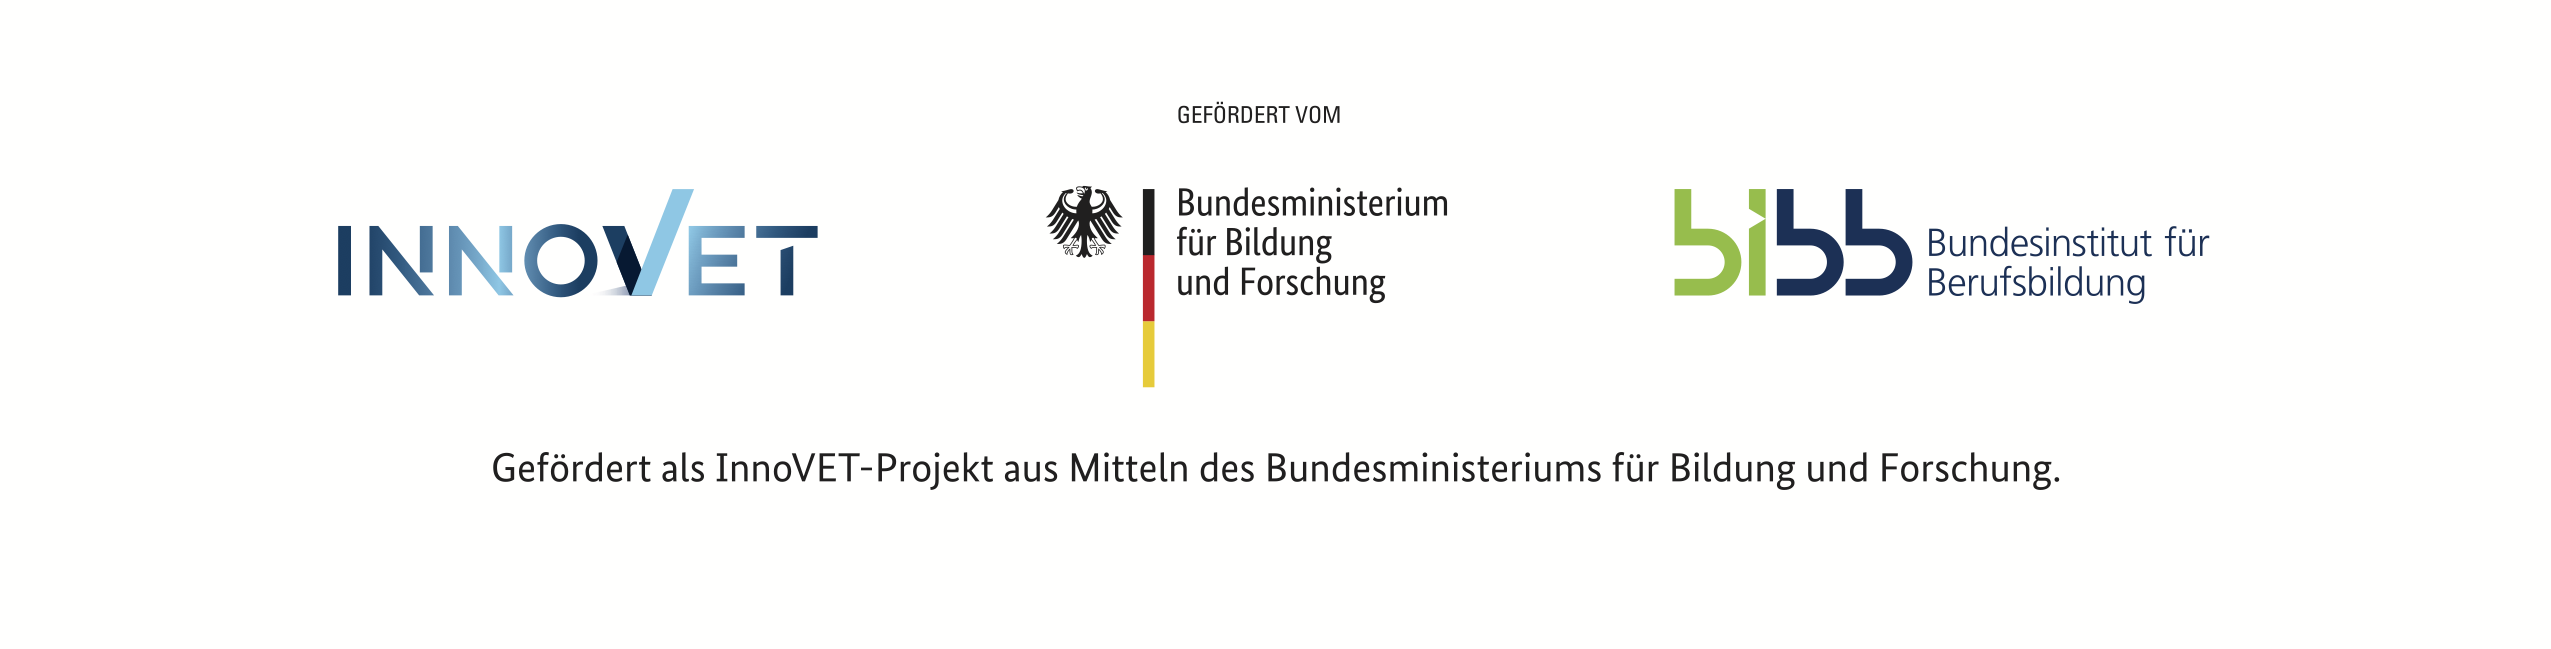

# Lizenzhinweis

Dieses Notebook "Feed Forward Networks und Maßnahmen gegen Overfitting" wurde von Kasra Habib und Antje Schweitzer, KI B3 / Universität Stuttgart, erstellt. 

Das Werk, mit Ausnahme der oben abgebildeten Förderlogos, ist lizenziert unter [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.de) (Namensnennung 4.0 International)

# Themen in diesem Notebook

* Feed Forward Networks: Implementierung in keras
* Einfluss der Initialisierung
* Optimierung
    * Vermeidung von Overfitting
        * Early Stopping
        * Dropout
        * L2 Regularisierung
    * Hyperparameter-Tuning
* Aufteilung in Test- und Trainingsdaten
    * Sinn von Validationsdaten und unabhängigen Testdaten


# Ziel dieses Projekts


Bei diesem Notebook geht es darum, mit einem einfachen Feed Forward Netzwerk Objekte in Bildern zu klassifizieren, es geht also um Bilderkennung. Dieses Projekt ist dazu gedacht, grundlegende Techniken beim Training von Deep-Learning-Modellen zu erklären. 

Hier werden exemplarisch sehr einfache Fotos von Kleidungsstücken klassifiziert. 

Zum Training des FNNs wird hier die Bibliothek *Keras* als nutzerfreundliches Interface zur Deep-Learning-Bibliothek *Tensorflow* verwendet. 

Typischerweise werden zur Bildklassifikation nicht FNNs, sondern CNNs verwendet. Ein späteres Notebook wird CNNs zur Bilderkennung auf denselben Daten einführen. 


# Benötigte Bibliotheken importieren

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf

Wir werden in diesem Notebook mehrmals Modelle trainieren. Da beim Training von Modellen an mehren Stellen der Zufall im Spiel ist (z.B. werden die Modelle mit zufälligen Parameter initialisiert), definieren wir hier eine Funktion, die die Zufallsgeneratoren aller beteiligten Bibliotheken gezielt mit einem bestimmten Wert initialisiert. So kann man, wenn gewünscht, vor jedem neuen Training die Generatoren wieder mit demselben Wert initialisieren und kann so bei mehreren Durchläufen im Notebook die Ergebnisse exakt reproduzieren. Leider ist nicht garantiert, dass diese Werte auch in einer anderen Tensorflow-Installation reproduziert werden können, aber immerhin können Sie selbst Ihre Ergebnisse besser nachvollziehen. 

In [ ]:
import os
import random

def set_random_state(seed_value):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.compat.v1.set_random_seed(seed_value)
    tf.random.set_seed(seed_value)

# wählen Sie hier irgendeinen Wert
# der Code weiter unten wird immer myseed als Wert für set_random_state verwenden
myseed = 142

# Daten

Wir nutzen hier einen Datensatz mit Fotos von Kleidungsstücken, die sehr bequem mithilfe eines Moduls der *Keras*-Bibliothek geladen werden können. Die Daten stammen ursprünglich von Zalando und stehen unter MIT Lizenz - diese Lizenz ermöglicht es, dass die Daten über *Keras* zur Verfügung gestellt werden. 

## Daten laden

Das Modul `datasets` in *Keras* bietet einige Datensätze, mit denen man typische Machine-Learning-Probleme lösen kann. Die Zalando-Daten werden hier unter dem Namen `fashion_mnist` geführt. 

Wir sehen als Allererstes in der Dokumentation des Datensatzes nach: 

[Beschreibung der Fashion MNIST Daten](https://keras.io/api/datasets/fashion_mnist/)

Laut Dokumentation besteht der Datensatz aus Bildern von Kleidungsstücken. Es gibt 10 verschiedene Klassen (hier ins Deutsche übersetzt): 

|Label|Klasse| 
|:-----:|:-----|
|0|T-Shirt oder Top|
|1|Hose|
|2|Pullover|
|3|Kleid|
|4|Mantel|
|5|Sandale|
|6|Hemd|
|7|Sneaker|
|8|Tasche|
|9|Stiefelette|

Der Dokumentation kann man außerdem noch entnehmen, dass die Bilder im Format 28x28 Pixel vorliegen, wobei jedes Pixel als ganzzahliger *Grayscale*-Wert zwischen 0 und 255 kodiert ist - das heißt, jede Zahl kodiert eine Graustufe zwischen 0 (weiß) und 255 (schwarz). 

*Keras* bietet laut Dokumentation eine Funktion namens `load_data()`, mit der man die Daten laden kann. Diese Funktion liefert die Daten als ein Paar von 2 Elementen, die jeweils wieder aus einem Paar von Elementen bestehen: das erste Paar sind die Trainingsdaten und die Klassen der Trainingsdaten, das zweite Paar die Testdaten und die Klassen der Testdaten. 

In [ ]:
# Beschreibung siehe https://keras.io/api/datasets/fashion_mnist/

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = fashion_mnist.load_data() 

X_train_orig.shape 

Wir haben nun also die Features der Trainingsdaten in der Variabe X_train_orig. Der Tensor hat die Form (60000, 28, 28) - es handelt sich um 60000 Bilder mit je 28x28 Pixeln. Die dazugehörigen korrekten Klassen für die Trainingsdaten sind in y_train_orig gespeichert. Analog sind die Features der Testdaten in X_test_orig und die korrekten Klassen in y_test_orig. 

## Die Daten anschauen


### Rohdaten

Wir sehen zuerst die Rohdaten an, hier am Beispiel des allerersten Datenpunkts. 

In [ ]:
# Index 0 in den Trainingsdaten
# Bilder bestehen aus 28 Zeilen von je 28 Pixeln
# jedes Pixel ist als Wert zwischen 0 und 255 kodiert
X_train_orig[0]

Man kann hier erkennen, dass die ersten drei Zeilen des ersten Bilds nur Nullen enthalten, ebenso die letzten paar Zeilen. Wir werden später sehen, dass das Bild oben und unten weiße Bereiche hat - und 0 entspricht der Farbe weiß. Ansonsten tauchen hier hauptsächlich Integer-Werte zwischen 0 und Werten im Bereich 200 auf; wir wissen aber, dass es theoretisch Werte bis zu 255 geben kann (dies entspricht dann dem tiefsten Schwarz). 

Wir sehen jetzt noch im Array mit den Klassen nach, zu welcher Kategorie dieses erste Bild gehört:

In [ ]:
# Index 0 in der Liste der Kategorien
# 9 bedeutet: Stiefel
y_train_orig[0]

Laut Dokumentation handelt es sich bei der Klasse 9 um Stiefel. 

### Als Bild

`matplotlib` bietet die Fuktion `imshow()` um Anzeigen von Bildern. Da die Bilder mit 28x28 Pixeln eine sehr geringe Auflösung haben, ist es nicht sinnvoll, sie sehr groß darzustellen - wir plotten hier daher gleich vier in einer Reihe, für 4 Datenpunkte. Der Übersicht halber schreiben wir die korrekte Klasse direkt als Bildüberschrift zu jedem Bild dazu. Dafür benötigen wir vorher noch einen Vektor mit den korrekten Klassen: hier entspricht die Position im Vektor der Nummer der Klasse. Stiefel steht an Stelle 9 im Vektor (gezählt wird wie üblich von 0!), da die Klasse 9 laut Dokumentation die Stiefel enthält. 

Damit man nicht immer die ersten 4 Bilder ansehen muss, führen wir die Variable offset ein - es werden dann immer die ersten 4 Bilder ab dem Offset gezeigt - ändern Sie die Variable, um andere Bilder zu sehen. 

In [ ]:
kleidungsarten = ["T-shirt", "Hose", "Pullover", "Kleid", "Mantel",
               "Sandale", "Shirt", "Turnschuh", "Tasche", "Stiefel"]

plt.figure()

# eine Reihe mit 4 Bildern
figure, panel = plt.subplots(1,4) 

# Offset, um ggf. Bilder ab einem bestimmten Index anzuzeigen
offset=14

# die ersten vier Bilder in je einem Panel der Grafik anzeigen
# cmap="binary" gibt an, dass es sich um schwarz/weiß Daten handelt
for i in range(4):
    # Bild anzeigen
    panel[i].imshow(X_train_orig[i+offset], cmap="binary")
    # Titel ergänzen: y_train_orig[i+offset] ergibt die Klasse, z.B. 9
    # dann entsprechendes Element aus kleidungsarten als Titel nehmen:
    # kleidungsarten[9] ergibt Stiefel
    panel[i].title.set_text(kleidungsarten[y_train_orig[i+offset]])

## Transformation der Bilddaten
Bevor wir die Bilddaten in dieses Netzwerk schicken können, normalisieren wir sie noch: wir wandeln sie so um, dass wir anstatt Werten zwischen 0 und 255 Werte zwischen 0 und 1 bekommen. Dies verhindert, dass durch die vielen Multiplikationen beim Training zu hohe Werte entstehen. 

Wir wollen hier nicht wie sonst oft mithilfe des Skalierers normalisieren, denn hier ist klar definiert, welcher Wert welcher Farbe entspricht. Wir wollen daher transparent so normalisieren, dass die Zuordnung von Wert zu Farbe immer fest ist. Deshalb teilen wir einfach jeden Wert durch 255 und sind damit sicher, dass alle Werte zwischen 0 und 1 liegen werden. 

In [ ]:
# Farbwerte normalisieren
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Variablen mit den korrekten Klassen analog zu den Trainingsdaten benennen 
y_train = y_train_orig
y_test = y_test_orig

# Einfaches Feed Forward Netzwerk 
Für ein performantes Netzwerk werden normalerweise viele Schichten mit sehr vielen Neuronen benötigt. Die hier genutzten Bilddaten sind nicht sehr groß, wir probieren es daher zunächst mit einem einfachen Feed Forward Netzwerk mit dem unten gezeigten Aufbau. 

![FeedForwardArchitektur.png](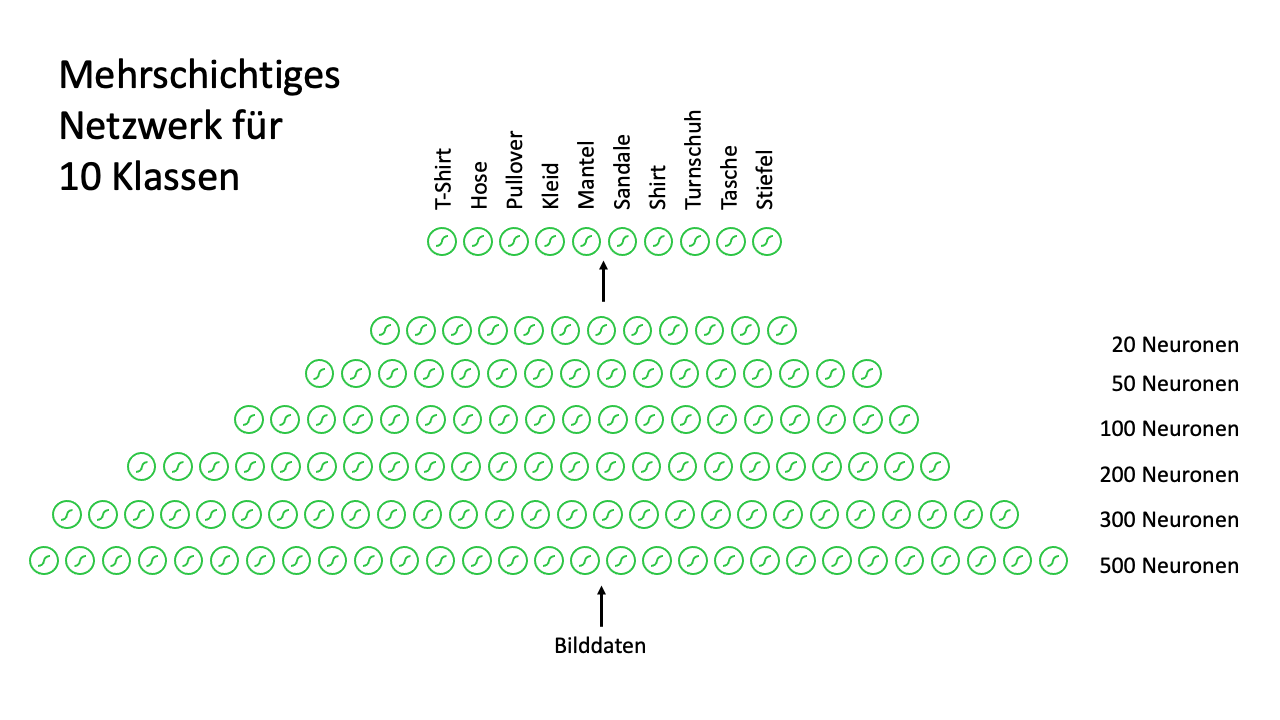
)

## Festlegen der Netzwerk-Architektur

Wir legen zunächst die Architektur fest: von unten beginnend die Input-Schicht mit Bildern von 28x28 Pixeln (entspricht 784 Pixeln), danach Schichten mit 500, 300, 200, 100, 50 Neuronen, und am Ende die Output-Schicht mit 10 Neuronen (einem Neuron pro möglicher Kleidungskategorie).

Die Ausgabe mit dem Überblick über die Modellarchitektur zeigt, dass damit 628660 Parameter zu trainieren sind.


In [ ]:
set_random_state(myseed)

tf.keras.backend.clear_session() # um ggf. Daten von Modellen aus einem früheren Durchlauf zu löschen

model_fnn = tf.keras.models.Sequential()

model_fnn.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model_fnn.add(tf.keras.layers.Dense(500, activation="relu")) # ReLU als Aktivierungsfunktion
model_fnn.add(tf.keras.layers.Dense(300, activation="relu"))
model_fnn.add(tf.keras.layers.Dense(200, activation="relu"))
model_fnn.add(tf.keras.layers.Dense(100, activation="relu"))
model_fnn.add(tf.keras.layers.Dense(50, activation="relu"))
model_fnn.add(tf.keras.layers.Dense(10, activation="softmax")) # Softmax als Aktivierungsfunktion für die letzte Schicht 

model_fnn.layers
model_fnn.summary() # Einen Überblick ausgeben lassen

## Training und Evaluierung
Wir starten nun das Training: angegeben werden die Trainingsdaten (X_train) sowie die für diese Daten korrekten Klassen (y_train), die Anzahl von Trainingsläufen (Epochen), sowie die Menge von Daten, die während des Trainings für die Validierung zurückbehalten werden soll (Validation Split, hier 20%). 

Es wäre auch möglich, die Testdaten als Validationsdaten während des Trainings zu verwenden, allerdings wird es später für uns noch interessant sein, abschließend die trainierten Modelle noch einmal auf noch gar nicht gesehenen Daten zu evaluieren. Für diesen Zweck behalten wir die "offiziellen" Testdaten (`X_test` und `y_test`) erst einmal zurück.

In [ ]:
# Details zum Training: wie soll optimiert und ausgewertet werden?
model_fnn.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

history_fnn = model_fnn.fit(X_train, y_train, epochs=10,validation_split=0.2)

Wir erreichen mit diesem Modell auf den Validationsdaten meistens eine Accuracy von um die 87-88% - d.h. ca. 87% der Kategorien werden dort korrekt erkannt. Die genaue Zahl schwankt etwas - da die Modellparameter zufällig initialisiert werden, ergeben sich in jedem Durchlauf leicht andere Zahlen. Falls Sie deutlich andere Werte bekommen, dürfte es sich um einen Ausreißer handeln, weil die Initialisierung besonders ungünstig war. Probieren Sie es ggf. aus, indem Sie einen neuen Durchlauf starten. Sie müssen in diesem Fall sowohl die Zelle mit der Konfiguration des Netzwerks (beginnend mit `model_fnn = tf.keras.models.Sequential()`) als auch die Zelle mit dem eigentlichen Training ausführen, sonst wird das bereits trainierte Netzwerk weiter trainiert. 

## Analyse

Nun stellt sich die Frage: hätte ein Modell mit dieser Architektur noch besser sein können? Da die Modelle immer mit zufälligen Parametern initialisiert werden und die Performanz auch von dieser Initialisierung abhängt, kann man das nie ganz sicher sagen. Wir können aber etwas Erkenntnis dazu aus der Analyse der Performanz während des Trainings ableiten. Dafür plotten wir zwei Grafiken, die zeigen, wie sich von Epoche zu Epoche die Genauigkeit und der Verlust auf den Trainings- und Validationsdaten entwickeln. Diese Werte wurden oben während des Trainings bereits ausgegeben, wir stellen sie nun grafisch dar. Sie haben solche Grafiken schon gesehen, als Grafiken von Teachable Machine, in den Folien zu Hyperparametern beim Training von Neuronalen Netzen. 

Der folgende Code definiert eine Funktion, die die Grafik für Ihr Modell plotten kann. Wir werden Sie später noch mehrmals verwenden. In der Zelle darunter sehen Sie die Grafik eines Modells, die in einem Durchlauf während der Entwicklung dieses Notebooks so erzeugt wurde. Diese wird unten diskutiert. Vergleichen Sie Ihr Ergebnis mit dieser Grafik. 

In [ ]:
# eine Funktion definieren, die den gewuenschten Plot erzeugt
# braucht als Argument das Ergebnis des Trainings (der Funktion fit)
def plot_valid(history):
    
    # Liste der Epochen im Training, kann der Länge der Liste von Accuracy-Werten entnommen werden
    epochs = range(1,len(history.history['accuracy'])+1)

    # Liste der Accuracys auf den Trainingsdaten und auf den Validationsdaten
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    # Liste der Verlustwerte auf beiden Daten
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # als Grafik plotten
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Trainingsdaten')
    plt.plot(epochs, val_loss, label='Validationsdaten')
    plt.legend(loc='upper right')
    plt.title('Verlust')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Trainingsdaten')
    plt.plot(epochs, val_acc, label='Validationsdaten')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.show()

# das Ergebnis des obigen Trainings hatten wir in history_fnn gespeichert
# damit nun die neue Funktion aufrufen
plot_valid(history_fnn)

![training_and_validation_fnn.png](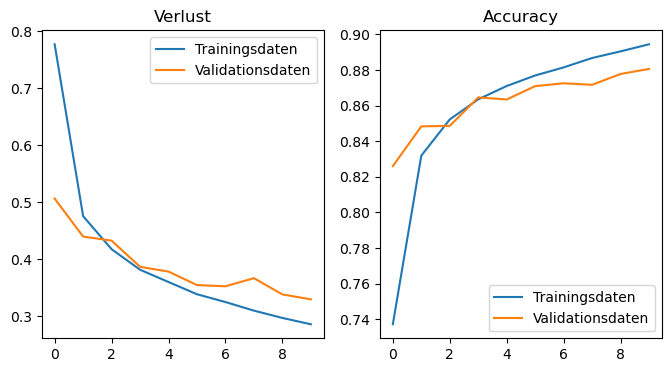
)

Oben sehen Sie das Ergebnis eines Durchlaufs während der Entwicklung dieses Notebooks. Dieser Durchlauf war übrigens zufällig besonders "gut", das Modell kam am Ende auf eine Accuracy von 88.06% auf den Validationsdaten. 

Man kann sehen, dass der Verlust im Laufe des Trainings immer kleiner wird. Das ist auch zu erwarten, schließlich wird beim Training der Verlust minimiert. Im allerersten Durchlauf, also in Epoche 0, ganz links, ist der Verlust auf den Trainingsdaten noch relativ groß, aber am Ende dieser Epoche wird auf den Validationsdaten evaluiert, und man kann hier bereits sehen, dass der Verlust auf den Validationsdaten dort zunächst kleiner ist als zu Beginn des Trainings - das Modell hat bereits etwas gelernt. In der zweiten Epoche (Epoche 1 in der Grafik also) ist dann auch der Verlust auf den Trainingsdaten deutlich kleiner. Am Ende dieser Epoche liegen wir bei den Validationsdaten sogar noch etwas niedriger - wieder deshalb, weil das Modell am Ende der Epoche etwas besser ist als währenddessen. Es ist aber dann bald der Punkt erreicht, wo der Verlust auf den Trainingsdaten kleiner ist als auf den Validationsdaten. In der Grafik oben ist das bereits bei Epoche 2 der Fall. Hier beginnt das Modell, auch Eigenheiten der Trainingsdaten zu lernen, die für die Validationsdaten keine Rolle spielen - es findet also Overfitting statt. Allerdings verbessert sich der Verlust auf den Validationsdaten im Verlauf des Trainings nach einer kurzen Verschlechterung in Epoche 7 auch auf den Validationsdaten noch weiter. 

Diese Entwicklung spiegelt sich ebenso in der Entwicklung der Genauigkeit (Accuracy) wieder: das Modell erreicht eine immer höhere Genauigkeit, mit einzelnen schlechteren Epochen zwischendurch. Auch die Accuracy ist aufgrund des Overfittings auf den Trainingsdaten besser als auf den Validationsdaten. 

Der oben stehenden Grafik kann man aber entnehmen, dass das Modell sich zuletzt weiter verbessert. Möglicherweise ist das in Ihrem Fall nicht so, jedes Modell ist anders. Aber hier kann man sehen, dass der Verlust (wieder) am Fallen war und die Genauigkeit am Steigen. Wir hatten oben eher willkürlich festgelegt, dass das Modell 10 Epochen lang trainiert wird - hätten wir länger trainieren sollen? Beim vorliegenden Modell vielleicht ja! In anderen Fällen vielleicht nicht, denn wenn man zu lange trainiert, riskiert man noch mehr Overfitting. Wenn Sie wollen, probieren Sie es aus, indem Sie für deutlich mehr als 10 Epochen trainieren. Dafür können Sie entweder nur die Zelle mit dem eigentlichen Training noch einmal unverändert ausführen. In diesem Fall wird das Modell nur weiter trainiert, und Sie sehen, wie sich Verlust und Genauigkeit im weiteren Verlauf weiterentwickelt hätten. Sie können aber auch das Netzwerk noch einmal neu konfigurieren, und dann in der Zelle mit dem Training die Zahl der Epochen auf einen größeren Wert setzen. Sie sehen dann anschließend in der Grafik den Verlauf des Trainings über alle Epochen. 

Die obige Grafik zeigt, dass es möglicherweise gut gewesen wäre, noch länger zu trainieren: das Modell verbessert sich in den letzten Epochen noch. Wir haben beim Thema "C7-4: Hyperparameter beim Training von neuronalen Netzen" Early Stopping angesprochen - eine Möglichkeit, erst im Laufe des Trainings zu entscheiden, wie lange trainiert werden soll. Dies probieren wir nun aus - es ermöglicht uns, das obige Modell länger zu trainieren, falls sinnvoll, oder umgekehrt früher abzubrechen (und damit Trainingszeit zu sparen), falls das Modell sich nicht mehr verbessert. In manchen Fällen würde der frühere Abbruch sogar verhindern, dass das Modell sich gegen Ende verschlechtert. Einen solchen Fall sehen Sie in dieser Grafik:


![training_and_validation_fnn_overfitting.png](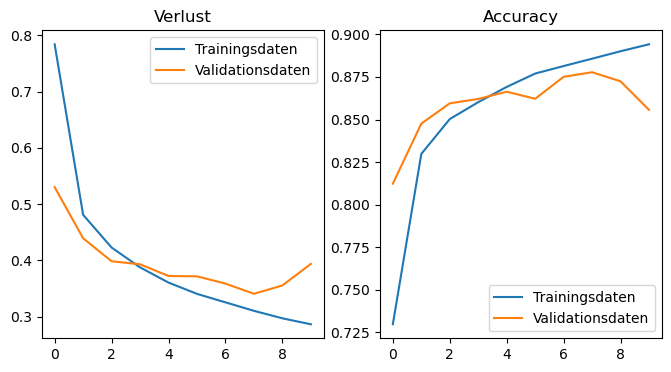
)

# Feed Forward Netzwerk mit Early Stopping

Um Early Stopping zu erreichen, übergeben wir beim Training des Modells eine sogenannte Rückruffunktion (engl. Callback), die das Training abbricht, falls bestimmte Bedingungen erfüllt sind. Wir nennen diese Funktion hier `callback`. Wir legen fest, dass die Entwicklung des Verlusts auf den Validationsdaten beobachtet werden soll (`monitor='val_loss'`). Wenn dieser sich 3 Epochen lang nicht verbessert (`patience=3`), soll das Training abgebrochen werden und die Parameter des Modells auf die Parameter aus der besten Epoche zurückgesetzt werden (`restore_best_weights=True`). Der Abbruch soll allerdings frühestens ab Epoche 5 passieren.

Da wir sowohl in diesem Durchlauf als auch im Durchlauf für das FNN ohne Early Stopping dieselbe Initialisierung für die Zufallsgeneratoren verwendet haben, sollten die Werte der ersten 10 Epochen hier identisch sein mit denen der 10 Epochen des Trainings oben. 

In [ ]:
set_random_state(myseed)

tf.keras.backend.clear_session() # um ggf. Daten von Modellen aus einem früheren Durchlauf zu löschen

model_fnn_early = tf.keras.models.Sequential()

model_fnn_early.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model_fnn_early.add(tf.keras.layers.Dense(500, activation="relu")) 
model_fnn_early.add(tf.keras.layers.Dense(300, activation="relu"))
model_fnn_early.add(tf.keras.layers.Dense(200, activation="relu"))
model_fnn_early.add(tf.keras.layers.Dense(100, activation="relu"))
model_fnn_early.add(tf.keras.layers.Dense(50, activation="relu"))
model_fnn_early.add(tf.keras.layers.Dense(10, activation="softmax")) 

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5,restore_best_weights = True)

tf.keras.backend.clear_session() 

model_fnn_early.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# maximal 30 Epochen, evtl. Abbruch vorher durch callback
history_fnn_early = model_fnn_early.fit(X_train, y_train, epochs=30,callbacks=[callback],validation_split=0.2)

In den meisten Fällen werden Sie hier feststellen, dass länger trainiert wird als 10 Epochen, und dass sich dabei die Performanz des Modells noch verbessert. Da wir als Parameter `restore_best_weights=True` angegeben haben, ist unser finales Modell dasjenige, das den kleinsten Verlust auf den Validationsdaten hatte, normalerweise das drittletzte, denn das Training wird ja abgebrochen, wenn der bisher niedrigste Verlust sich 3 Epochen lang nicht weiter verbessert. Suchen Sie die entsprechende Zeile im Output - die dort angegebene `val_accuracy` ist die Accuracy, die Sie mit dem fertig trainierten Modell auf den Validationsdaten erreichen.  

Wir sehen uns auch hier noch die Entwicklung grafisch dargestellt an:

In [ ]:
plot_valid(history_fnn_early)

Dieser Grafik kann man meist entnehmen, dass sich die Performanz in den letzten Epochen kaum verbessert - es vergrößert sich lediglich die Schere zwischen der Accuracy auf den Validationsdaten und der Accuracy auf den Trainingsdaten. Die unten stehende Grafik zeigt einen Beispieldurchlauf, der während der Entwicklung dieses Notebook stattfand. Dabei wurde das Netzwerk mit denselben Parametern initialisiert wie das oben diskutierte FNN - wir sehen also hier, was das weitere Training gebracht hätte. Im konkreten Fall verbesserte sich das Modell durch das längere Training übrigens zufällig um genau 1%, von 88.06% auf 89.06% in der besten Epoche. Das ist relativ viel; die Verbesserung ist oft auch weniger deutlich.

Die Accuracy auf den Trainingsdaten verbessert sich also zuletzt recht wenig. Aber auf den Trainingsdaten steigt sie weiter und weiter. Das bedeutet, dass sich das Modell besser und besser an die Trainingsdaten anpasst, es findet mehr und mehr Overfitting statt. Eine Möglichkeit, Overfitting zu verhindern, ist, mehr Daten zum Training zu verwenden - allerdings haben wir hier nicht mehr Daten. Eine weitere Möglichkeit ist aber, sogenannte Dropout-Schichten zu verwenden. Diese sehen wir uns im nächsten Abschnitt an. 

![training_and_validation_ffn_early.png](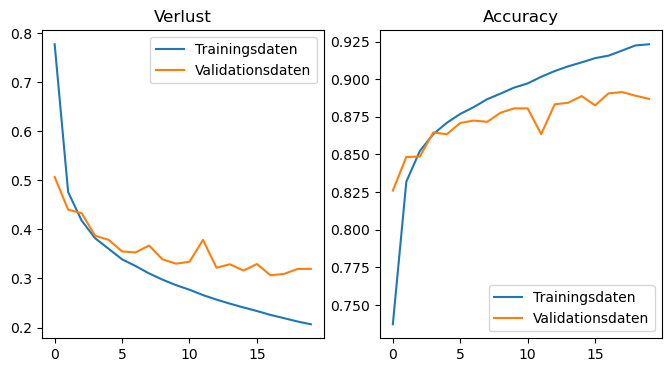
)

# FNN mit Dropout

Unser FNN lernt hier, Muster in der Verteilung der Grayscale-Werte der 784 Pixel zu identifizieren, die typisch sind für bestimmte Klassen. Möglicherweise lernt es aber dabei, die Zuordnung zu einer Klasse an nur sehr wenigen bestimmten Werten festzumachen, d.h. es gibt möglicherweise Gewichte in diesem Netzwerk, die auf eine ganz spezifische Kombination von Werten in bestimmten Pixeln "reagieren". Um das Ganze etwas robuster zu machen (und dadurch zu vermeiden, sich zu stark auf einzelne Bilder in den Trainingsdaten zu konzentrieren), kann man bei jedem Durchlauf zufällig einige Gewichte auf Null setzen. Dadurch ist das Netzwerk sozusagen gezwungen, die Entscheidung für eine Klasse auf mehrere typische Muster zu stützen. 

Dies wird erreicht, indem man im Netzwerk sogenannte Dropout-Schichten einbaut. Als Parameter kann man angeben, welcher Anteil an Gewichten zufällig auf Null gesetzt werden soll. Wir bauen hier nach jeder Schicht eine Dropout-Schicht ein. Dabei verwenden wir als Anteil 0.2, d.h., 20% der Gewichte werden nach jeder Schicht auf Null gesetzt. 

Dropout-Schichten verlängern das Training - es ist natürlich schwieriger, Regelmäßigkeiten zu lernen, wenn man dabei sozusagen sabotiert wird. Aber das Endergebnis ist robuster, es werden mehr generell gültige Muster gelernt und weniger die Eigenheiten einzelner Bilder in den Trainingsdaten. 

Wir verlängern das Training auf maximal 40 Epochen - durch das Early Stopping bricht das Training ja sowieso ggf. früher ab, d.h., es wird wirklich nur so lange trainiert, wenn das Netzwerk sich noch verbessert. 

In [ ]:
set_random_state(myseed)

tf.keras.backend.clear_session() # um ggf. Daten von Modellen aus einem früheren Durchlauf zu löschen

model_fnn_early_dropout = tf.keras.models.Sequential()

model_fnn_early_dropout.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model_fnn_early_dropout.add(tf.keras.layers.Dense(500, activation="relu")) 
# Dropout-Schicht, bei der 20% der Parameter auf 0 gesetzt werden
model_fnn_early_dropout.add(tf.keras.layers.Dropout(0.2))
model_fnn_early_dropout.add(tf.keras.layers.Dense(300, activation="relu"))
model_fnn_early_dropout.add(tf.keras.layers.Dropout(0.2))
model_fnn_early_dropout.add(tf.keras.layers.Dense(200, activation="relu"))
model_fnn_early_dropout.add(tf.keras.layers.Dropout(0.2))
model_fnn_early_dropout.add(tf.keras.layers.Dense(100, activation="relu"))
model_fnn_early_dropout.add(tf.keras.layers.Dropout(0.2))
model_fnn_early_dropout.add(tf.keras.layers.Dense(50, activation="relu"))
model_fnn_early_dropout.add(tf.keras.layers.Dropout(0.2))
model_fnn_early_dropout.add(tf.keras.layers.Dense(10, activation="softmax")) 

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5, restore_best_weights=True)

# Details zum Training: wie soll optimiert und ausgewertet werden?
model_fnn_early_dropout.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

history_fnn_early_dropout = model_fnn_early_dropout.fit(X_train, y_train, epochs=40,callbacks=[callback],validation_split=0.2)

In [ ]:
plot_valid(history_fnn_early_dropout)

![training_and_validation_fnn_early_dropout.png](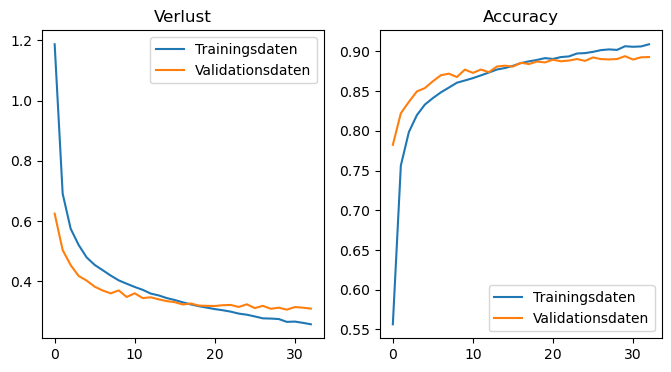
)

Die oben stehende Grafik zeigt einen Durchlauf mit Dropout. Hier brach das Training nach 33 Epochen ab; die beste Accuracy auf den Validationsdaten war 89.4%. Das Modell wurde mit denselben Parametern initialisiert wie die Modelle davor. Wir erreichen hier also noch einmal eine moderate Verbesserung um 0.34%. 

Vor allem aber kann man hier sehr gut sehen, dass das Overfitting deutlich reduziert wurde: die Kurven für Trainings- und Validationsdaten liegen sehr viel näher beieinander und der Punkt, an dem die Performanz auf den Validationsdaten unter die auf den Trainingsdaten sinkt, ist erst sehr viel später erreicht. Die Dropout-Schichten waren also erfolgreich. 

Falls Sie sehr genau aufgepasst haben, ist Ihnen vielleicht aufgefallen, dass das neue Modell auf den Trainingsdaten schlechter ist als das vorige - im Durchlauf oben zum Beispiel wurde mit den Dropout-Schichten beim Training in Epoche 15 auf den Trainingsdaten eine Accuracy von 87.91% erreicht. Mit dem vorigen Modell dagegen, ohne die Dropout-Schichten, ergab sich auf den Trainingsdaten in Epoche 15 eine Accuracy von 91.11%. Dies liegt daran, dass die Daten während des Trainings nun "schwieriger" sind, weil durch die Dropout-Schichten Information verloren geht. Genau dieser Effekt zwingt das Modell, robuster zu werden - es ist gezwungen, sich bei der Klassifikation auf mehrere Features der Daten zu konzentrieren. Dadurch funktioniert die Klassifikation auch noch korrekt, wenn eines der Features durch Dropout entfällt. 

Die Validationsdaten sind von diesem Nachteil durch ausfallende Datenpunkte allerdings nicht betroffen - bei der Evaluierung auf den Validationsdaten wird das fertig trainierte Modell einfach auf neue Daten angewandt, und dabei will man natürlich nicht "freiwillig" Datenpunkte eliminieren - das Modell soll ja möglichst gut sein und nutzt daher bei der Anwendung kein Dropout. 

[Bemerkung für Fortgeschrittene: Das hat übrigens zur Konsequenz, dass bei der Anwendung von Modellen mit Dropout auf neue Daten "nachjustiert" werden muss: Die Outputs von Dropout-Schichten in darüber liegende Schichten liefern ohne Dropout ungewohnt hohe Werte - da die Neuronen in der darüber liegenden Schicht plötzlich von allen Neuronen der darunter liegenden Dropout-Schicht "gefüttert" werden. Es ist daher üblich, im Training alle Werte der Inputs, die nicht durch Dropout ausfallen, mit einem Faktor zu skalieren, so dass auch im Training in der darüber liegenden Schicht so hohe Werte ankommen wie später ohne Dropout. Dieses Verfahren wird als Inverted Dropout bezeichnet. Darum kümmert sich allerdings Keras, wir als Benutzer sehen davon nichts.]

# Stabilität der Ergebnisse

Wir sehen uns nun die Ergebnisse nochmal im Überblick an. Der folgende Code berechnet die Werte für die drei Modelle. Um zu erreichen, dass genau auf den Validationsdaten evaluiert wird, muss man wissen, dass tensorflow bei der Angabe `validation_split=0.2` die letzten 20% der übergebenen Daten als Validationsdaten verwendet. Da wir 60000 Datenpunkte übergeben hatten, werden die letzten 12000 zur Validierung verwendet. Wir können daher der Funktion `evaluate()` direkt die letzten 12000 Datenpunkte und die letzten 12000 Klassen als Testdaten übergeben und sollten dann genau die oben erreichten Accuracys hier noch einmal im Überblick bekommen. 

Bedenken Sie, dass bei den Modellen mit Early Stopping nach dem Training die Parameter auf die Parameter der Epoche zurückgesetzt wurden, in der der Verlust auf den Validationsdaten am niedrigsten war. Sie sehen hier also jeweils die Accuracy, die oben in der entsprechenden Epoche ausgegeben wurde, normalerweise also *nicht* die oben in der letzten Epoche ausgegebene Accuracy. 

Die Evaluierung wird manchmal in mehren Schritten erledigt, die finalen Zahlen sind in der Zeile zu finden, die mit dem durchgehenden doppelten Balken markiert ist  - unvollständige Balken bedeuten, dass die Evaluierung noch nicht abgeschlossen ist: 

[==============================] 


In [ ]:
X_valid = X_train[-12000:]
y_valid = y_train[-12000:]

model_fnn.evaluate(X_valid,y_valid)
model_fnn_early.evaluate(X_valid,y_valid)
model_fnn_early_dropout.evaluate(X_valid,y_valid)

Um zu zeigen, dass die Ergebnisse auch von den Daten abhängen, auf denen evaluiert wird, sehen wir uns jetzt noch an, welche Accuracys die Modelle auf den bisher noch gar nicht gesehenen Testdaten erreichen. 

Die Evaluierung auf den unabhängigen Testdaten ist nicht nur interessant, sondern hier auch dringend angeraten. Denn wir haben zwar nicht direkt auf den Validationsdaten trainiert, aber wir haben sie immerhin verwendet, um zu entscheiden, wann bei Early Stopping das Training abgebrochen werden soll. D.h. wir haben aus dem Trainingsdurchlauf das Modell ausgewählt, das auf den Validatonsdaten am besten war - damit kann man das Modell eigentlich gar nicht wirklich objektiv abschließend evaluieren. Insofern ist es gut, dass wir die Testdaten zurückbehalten hatten. 

In [ ]:
model_fnn.evaluate(X_test, y_test)
model_fnn_early.evaluate(X_test, y_test)
model_fnn_early_dropout.evaluate(X_test, y_test)

Es ist schwierig, mit nur einem Durchlauf pro Modell zu beurteilen, wie hilfreich Early Stopping und Dropout sind. Sie bekommen deshalb hier eine Auflistung von Evaluierungsergebnissen aus mehreren Durchläufen während der Entwicklung dieses Notebooks. Diese wurden mit verschiedenen Random Seeds, also mit verschiedenen Initialisierungen für die Zufallsgeneratoren erreicht. 

Die folgende Tabelle zeigt die Evaluierung der jeweiligen Modelle. In der jeweils ersten Zeile sehen Sie die Evaluierungsergebnisse auf den Validationsdaten. Das heißt, Sie sehen die Zahlen, die oben während des Trainings ausgegeben wurden. Die Spalte "FNN" zeigt die Werte für das zuerst trainierte einfachste Modell. Die Spalte "+Early Stopping" bezeichnet die Werte für das Modell, das mit Early Stopping länger trainiert wurde. Danach ist angegeben, um wie viel dieses Modell das vorige Modell verbessert. Anschließend sehen Sie unter "+Dropout" das Modell mit Dropout und Early Stopping, und anschließend, um wie viel sich dieses Modell gegenüber dem Modell mit Early Stopping ohne Dropout verändert hat. 


|Random Seed|Daten| FNN | +Early Stopping | Verbesserung | +Dropout | Verbesserung |
|:-----|:-----|:-----:|:-----:|:-----:|:-----:|:-----:|
| 142 | Validation | 88.06 | 89.06 | +1.00 | 89.40 | +0.34 |
|     | Testdaten | 87.11 | 88.31 | +1.2 | 88.47 | +0.16 |
| 321 | Validation | 88.36 | 88.68 | +0.32 | 88.56 | -0.12 |
|     | Testdaten | 87.32 | 87.67 | +0.35 | 87.73 | +0.06 |
|1001 | Validation | 87.73 | 87.73 | +0.00 | 88.88 | +1.15 |
|     | Testdaten | 86.97 | 86.97 | +0.00 | 87.81 | +0.84 |
| 42 | Validation | 88.18 | 88.73 | +0.55 | 88.81 | +0.08 |
|     | Testdaten | 87.34 | 87.89 | +0.55 | 88.03 | +0.14 |
| 333 | Validation | 87.73 | 88.65 | +0.92 | 88.73 | +0.08 |
|     | Testdaten | 86.98 | 87.68 | +0.70 | 87.64 | -0.04 |
| 456 | Validation | 88.20 | 88.54 | +0.34 | 88.84 | +0.30 |
|     | Testdaten | 87.37 | 87.99 | +0.62 | 88.10 | +0.11 |

Der Tabelle können Sie entnehmen, dass der erste Durchlauf während der Entwicklung des Notebooks (hier: Random Seed 142) ein Glücksfall war - zwei der drei Modelle sind besser als die entsprechenden Modelle mit den fünf anderen Random Seeds. Dies sind außerdem die einzigen beiden Modelle mit Accuracys von über 90%.

Generell scheint es so zu sein, dass das längere Training mit Early Stopping die Modelle fast immer verbessert hat - mit der Ausnahme der Modelle mit Random Seed 1001, wo das Modell in Epoche 10 zufällig bereits das beste war, so dass dieses Modell auch das finale Modell beim Early Stopping war. Die Verbesserung ist dann jeweils im Bereich von ca. 0.3% bis 1%. 

Die Verbesserung durch Dropout ist häufig geringer; in wenigen Fällen sogar eine geringfügige Verschlechterung. Es ist allerdings bemerkenswert, dass z.B. das Modell bei Random Seed 321 war mit Dropout eine Verschlechterung von 0.12% aufweist, aber immerhin robuster zu sein scheint, denn auf den unabhängigen Testdaten ist es etwas besser als das Modell ohne Dropout. Es gibt auch Fälle, in denen die Verbesserung durch das robustere Modell mit Dropout deutlich ist - hier z.B. für das Modell mit Random Seed 1001, mit einer Verbesserung von 1.15%. Das ist übrigens das Modell, bei dem Early Stopping nicht geholfen hatte. 

Vielleicht ist Ihnen aufgefallen, dass die Werte auf den Testdaten grundsätzlich niedriger sind als auf den Validationsdaten. Das könnte zum Teil daran liegen, dass zumindest die Modelle mit Early Stopping auf den Validationsdaten optimiert wurden, wie oben bereits angesprochen. Es könnte auch daran liegen, dass die Testdaten zufällig "schwieriger" sind als die Fälle in den Trainingsdaten. 

Es gibt aber noch einen wichtigen Unterschied zwischen Test- und Validationsdaten, der möglicherweise auch eine Rolle spielt: die Testdaten sind so gewählt, dass sie gleich viele Fälle von jeder Klasse enthalten. Ebenso enthaltne die Trainingsdaten gleich viele Exemplare jeder Klasse. Dies ist beim Training von Machine Learning-Modellen übrigens sehr wichtig. 

Die Validationsdaten wurden von tensorflow dagegen einfach vom Ende der Trainingsdaten zurückbehalten, und daher ist es unwahrscheinlich, dass die Verteilung der Klassen in den Validationsdaten ganz ausgewogen ist. Und ebenso ist auch die Verteilung der Klassen in dem Teil der Trainingsdaten, die tatsächlich zum Training benutzt wurden, wahrscheinlich nicht ganz ausgewogen. Die Verteilung kann man z.B. mit der Funktion `histogram()` aus der `numpy`-Bibliothek anzeigen lassen (wir zeigen direkt das erste Element an, das die Häufigkeiten angibt):

In [ ]:
np.histogram(y_test)[0]

Wir haben also 1000 Exemplare pro Klasse in den Testdaten. Dagegen haben wir nur in etwa 1000 Exemplare pro Klasse in den Validationsdaten (wie oben besprochen, sind das die letzten 12000 Datenpunkte der Trainingsdaten):

In [ ]:
np.histogram(y_valid)[0]

# Projekte zum Ausprobieren

## Ausgewogene Trainingsdaten

Sie können nun ausprobieren, wie sich die Modelle verändern, wenn Sie gezielt ausgewogene Trainingsdaten und ausgewogene Validationsdaten verwenden. Wir haben bisher immer beim Training einfach den gewünschten `validation_split=0.2` angegeben. Wir können statt dessen aber auch getrennte Trainings- und Validationsdaten angeben. Dies bedeutet aber, dass wir uns selbst darum kümmern müssen, Validationsdaten mit ausgewogener Klassenverteilung zu generieren. Dafür können Sie die bereits aus dem Notebook zu Evaluationsmaßen bekannte Funktion `test_training_split` verwenden. Sie bietet die Möglichkeit, als Argument z.B. `stratify=y_train` anzugeben. Dies stellt sicher, dass die Klassenverteilung in den beiden neu entstehenden Mengen so ist wie in y_train, also wie in den (perfekt ausgewogenen) bisherigen Trainingsdaten. Das könnte z.B. so aussehen:

```
# wir stellen erst sicher, dass X_train und y_train definiert sind wie am Anfang dieses Notebooks
# Farbwerte normalisieren
X_train = X_train_orig / 255.
y_train = y_train_orig

# dann X_train und y_train neu generieren
# Test-Training-Split, bei dem der Anteil der verschiedenen Klassen 
# in beiden Teilmengen gleich wie in den bisherigen Trainingsdaten ist (stratify=y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=12000, stratify=y_train, random_state=42)
```

Sie könnten dann sicherheitshalber überprüfen, ob die Klassen nun wirklich gleich verteilt sind: 

```
np.histogram(y_valid)[0]
np.histogram(y_train)[0]
```

Bauen Sie den Code zur Erstellung der verbesserten Trainings- und Validationsdaten ganz oben im Notebook ein. Trainieren Sie anschließend die Modelle mit folgenden Argumenten und lassen Sie dafür `validation_split=0.2` weg:

```
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid))
```

Achtung, passen Sie die Variablennamen für history und model entsprechend an, und ergänzen Sie die gewüschte Anzahl von Epochen sowie ggf. die Callbacks. 

Bitte denken Sie daran, dass wir vorhin im Abschnitt "Stabilität der Ergebnisse" `X_valid` und `y_valid` als die letzten 12000 Datenpunkte der Trainingsdaten definiert hatten. Dies dürfen Sie natürlich dann nicht mehr tun. Wenn Sie den Code oben verwenden, sind `X_valid` und `y_valid` bereits korrekt definiert. Kommentieren Sie also im Abschnitt "Stabilität der Ergebnisse" die Zeilen, die `X_valid` und `y_valid` festlegen, oder löschen Sie sie ganz, sonst überschreiben Sie Ihre neue Aufteilung.  

Die Anpassung bleibt Ihnen überlassen, aber die folgende Tabelle zeigt, wie sich die Modelle für alle oben ausprobierten Random Seeds verändern könnten, wenn man den Code entsprechend modifiziert. Achtung, bei Ihnen ergeben sich möglicherweise andere Zahlen, selbst wenn die Random Seeds wie hier gewählt werden. Initialisierungen können sich von Tensorflow-Installation zu Tensorflow-Installation unterscheiden. 

| Random Seed|Daten| FNN | +Early Stopping | Verbesserung | +Dropout | Verbesserung |
|:-----|:-----|:-----:|:-----:|:-----:|:-----:|:-----:|
| 142 bisher | Validation (alt) | 88.06 | 89.06 | +1.00 | 89.40 | +0.34 |
|            | Testdaten        | 87.11 | 88.31 | +1.2 | 88.47 | +0.16 |
| 142 neu    | Validation (neu) | 88.02 | 88.68 | +0.66 | 89.15 | +0.47 |
|            | Testdaten        | 86.75 | 87.45 | +0.70 | 88.19 | +0.74 |
| 321 bisher | Validation (alt) | 88.36 | 88.68 | +0.32 | 88.56 | -0.12 |
|            | Testdaten        | 87.32 | 87.67 | +0.35 | 87.73 | +0.06 |
| 321 neu    | Validation (neu) | 88.10 |**89.59**| +0.32 |**89.21**| -0.12 |
|            | Testdaten        | 86.86 |**88.45**| +1.59 |**88.04**| -0.41 |
|1001 bisher | Validation (alt) | 87.73 | 87.73 | +0.00 | 88.88 | +1.15 |
|            | Testdaten        | 86.97 | 86.97 | +0.00 | 87.81 | +0.84 |
|1001 neu    | Validation (neu) |**88.47**|**89.19**| +0.72 |**89.46**| +0.27 |
|            | Testdaten        |**87.50**|**87.79**| +0.29 |**88.28**| +0.49 |
| 42 bisher  | Validation (alt) | 88.18 | 88.73 | +0.55 | 88.81 | +0.08 |
|            | Testdaten        | 87.34 | 87.89 | +0.55 | 88.03 | +0.14 |
| 42 neu     | Validation (neu) | 87.99 |**89.14**| +1.15 |**89.02**| -0.12 |
|            | Testdaten        | 86.71 |**88.49**| +0.78 |87.74| -0.75 |
| 333 bisher | Validation (alt) | 87.73 | 88.65 | +0.92 | 88.73 | +0.08 |
|            | Testdaten        | 86.98 | 87.68 | +0.70 | 87.64 | -0.04 |
| 333 neu    | Validation (neu) |**88.60**|**88.72**| +0.12 |**89.68**| +0.96 |
|            | Testdaten        |**87.50**| 87.67 | +0.17 |**88.45**| +0.78 |
| 456 bisher | Validation (alt) | 88.20 | 88.54 | +0.34 | 88.84 | +0.30 |
|            | Testdaten        | 87.37 | 87.99 | +0.62 | 88.10 | +0.11 |
| 456 neu    | Validation (neu) |**88.59**|**89.32**| +0.73 | 88.45 | -0.87 |
|            | Testdaten        | 87.28 |**88.06**| +0.78 | 87.83 | -0.23 |

Hier wurden 18 neue Modelle trainiert (3 Modelle mit 6 verschiedenen Random Seeds) und auf je 2 Datenmengen evaluiert - einmal auf den Validationsdaten, einmal auf den Testdaten. D.h. wir haben 36 neue Evaluierungsergebnisse. Davon sind 21 besser als vorher (diese sind fett markiert). Dies spricht dafür, dass die minimal besser ausgewogenen Trainings- und Validationsdaten von Vorteil waren: ca. 2/3 der Durchläufe ergeben bessere Evaluierungswerte. 

Die Daten zeigen auch, dass Random Seeds, bei denen sich vorher eine hohe Accuracy ergab, nicht notwendigerweise auf den veränderten Trainingsdaten wieder gut sind. Mit den früheren Trainings- und Validationsdaten ergab sich unter den ausprobierten Random Seeds das beste Modell (mit 89.40%) bei Random Seed 142 für das Modell mit Dropout. Dieses Mal wurde das beste Modell (mit 89.68%) mit Random Seed 333 trainiert - ebenfalls mit Dropout. Das war zu erwarten - tendenziell sollte Dropout bessere Ergebnisse liefern, denn wenn man eine zu starke Anpassung an die Trainingsdaten vermeidet, sollte das Modell besser auf andere Daten wie eben die Validationsdaten übertragbar sein - wenn auch nicht immer, so doch meistens. Ebenso ist es nicht verwunderlich, dass das bisher ingesamt beste Modell auf den verbesserten, ausgewogeneren Trainingsdaten trainiert wurde. 

Es bleibt aber zu beobachten, dass es bei diesen Daten wirklich immer auf den unabhängigen Testdaten (die übrigens unverändert geblieben sind) schlechtere Ergebnisse gab. Dies spricht dafür, dass hier zufällig in den Testdaten "schwierigere" Bilder enthalten sein könnten. 


## L2 Regularisierung

Sie haben oben Dropout kennengelernt als Möglichkeit, Overfitting zu reduzieren. Dropout ist eine sogenannte Regularisierungstechnik. Es verhindert die übermäßige Anpassung an Eigenheiten der Trainingsdaten und sorgt insofern für weniger komplexe (weniger spezifische) Netzwerke.  

Eine weitere Möglichkeit zur Reduzierung der Komplexität eines Netzwerks sind L1- und L2-Regularisierung. Beim Training des Netzwerks verändern sich die Gewichte der verschiedenen Schichten. Dabei kann es vorkommen, dass für einzelne Gewichte sehr große Werte entstehen. Dies führt sozusagen dazu, dass das zugehörige Neuron sehr großen Einfluss bekommt. Dagegen spricht eigentlich nichts, wenn es sich um ein Neuron handelt, das Input von Features in den Daten bekommt, die für die korrekte Vorhersage wichtig sind. Es kann aber auch sein, dass es sich um ein Neuron handelt, das Input von Features bekommt, die in den Trainingsdaten nur zufällig für die Vorhersage hilfreich sind - die aber in Wirklichkeit gar nicht typisch sind und daher in Testdaten für eine falsche Vorhersage sorgen würden. Vereinfacht gesagt: große Gewichte können sinnvoll sein, aber sie können ebenso gut ein Resultat von Overfitting sein. 

Daher kann es sinnvoll sein, beim Training nicht nur darauf zu achten, dass der Fehler (der Verlust) immer kleiner wird. Man kann zusätzlich versuchen, das Entstehen großer Gewichte zu bestrafen. Genau das ist der Zweck von L1- und L2-Regularisierung. Beide Techniken funktionieren sehr ähnlich: die Verlustfunktion wird so modifiziert, dass zum eigentlichen Fehler noch die Werte aller Gewichte addiert werden. Da beim Training der Verlust minimiert wird, wird so nicht nur der Fehler möglichst klein gehalten, sondern gleichzeitig auch die Gewichte. Große Gewichte kommen dann nur noch vor, wenn sie den Fehler deutlich kleiner machen, wenn sie also in vielen Fällen im Training hilfreich sind (Gewichte, die nur in Einzelfällen hilfreich sind, haben fast keinen Einfluss auf den Fehler, da sie den Fehler nur für einen einzigen Datenpunkt verkleinern und so den Gesamtfehler kaum verändern). 

Damit sich positive und negative Gewichte hier nicht gegenseitig aufheben, gibt es zwei naheliegende Optionen: entweder, man addiert zum eigentlichen Fehler die absoluten Beträge der Gewichte (mathematisch gesehen die sogenannte L1-Norm). Dann spricht man von L1-Regularisierung. Oder man addiert zum Fehler die quadrierten Gewichte (mathematisch gesehen das Quadrat der sogenannten L2-Norm). Dann spricht man von L2-Regularisierung. Eine andere Bezeichnung für L2-Regularisierung ist *Weight Decay* (zu Deutsch in etwa: *Gewichteverfall* - da die Gewichte im Verlauf kleiner werden). In beiden Fällen, also bei L1- und L2-Regularisierung, werden diese "Bestrafungs"-Werte übrigens noch mit einem kleinen Faktor multipliziert, damit sie im Verhältnis zum eigentlichen Fehler nicht zu groß werden. 

Keras bietet die Möglichkeit, diese Werte Schicht für Schicht zu berechnen, so dass sie dann bei der Berechnung des Verlusts mit einfließen. Dafür wird bei der Konfiguration des Netzwerks jede Schicht, deren Gewichte so reguliert werden sollen, um das Argument `kernel_regularizer=tf.keras.regularizers.L2(0.001)` ergänzt. Dies sagt aus, dass die Funktion `regularizers.L2` für die Berechnung genutzt werden soll - diese implementiert die L2-Regularisierung für alle Verbindungen zwischen Neuronen (d.h. nicht für den Bias). Diese Funktion bekommt hier als Argument noch den gewünschten Faktor, hier 0.001 (der Standard-Wert, den man bekommt, wenn man kein Argument angibt, ist 0.01). Im obigen Beispiel könnte man also jede der `Dense`-Schichten um dieses Argument ergänzen. (Für die Dropout-Schichten ist das natürlich nicht nötig, sie haben ja keine Gewichte.)

So könnte z.B. die Schicht mit den 100 Neuronen aus dem obigen Beispiel so konfiguriert werden:

```
model_fnn_early_dropout.add(tf.keras.layers.Dense(100, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.001)))
```

Probieren Sie es aus! Hilft es, die Schichten im einfachen FNN (mit Early Stopping) zu ergänzen? Hilft es, sie im Dropout-Modell zu ergänzen? 

Bitte beachten Sie, dass Sie in beiden Fällen vermutlich die maximale Anzahl von Epochen erhöhen müssen - die Regularisierung verlängert das Training. 


## Andere Hyperparameter

Bei der Konfiguration des Netzwerks und der Festlegung der Trainingsparameter sind viele Entscheidungen zu treffen, die einen Einfluss auf die Performanz haben. 

Ein einfacher Parameter, den wir schon verwendet haben, ist der Parameter `patience`, der beim Early Stopping darüber entscheidet, wie lange man Verschlechterungen im jeweils gewählten Evaluationsparameter akzeptiert, ohne das Training zu beenden. *Patience* ist Englisch und bedeutet *Geduld*. Wir hatten oben nicht viel Geduld und haben verlangt, dass das Modell spätestens nach 3 Epochen wieder besser sein muss, sonst wurde per Early Stopping abgebrochen. Es macht manchmal aber vielleicht Sinn, länger abzuwarten, ob sich die Werte nicht doch noch verbessern. Außerdem gibt es oft Anwendungsfälle, in denen über sehr viele Epochen trainiert wird, über Tausende zum Beispiel - in solchen Fällen sollte man sehr viel höhere Werte für `patience` verwenden als die 3... 

Es ist sinnvoll, sich die Entwicklung des Verlusts über das Training hinweg anzusehen - wenn die Ergebnisse für Trainingsdaten und Validationsdaten noch nahe beieinander liegen, kann man hoffen, dass die Werte sich auch für die Validierungsdaten noch verbessern. Laufen die Kurven aber stark auseinander, verbessern sich die Werte auf den Trainingsdaten also deutlich, während sie sich auf den Validationsdaten eher verschlechtern, so ist eher nicht mehr zu erwarten, dass das Modell sich verbessert - es findet einfach nur mehr Overfitting auf den Trainingsdaten statt. 

Eine weitere Entscheidung, die getroffen werden muss, und die potentiell die Festlegung weiterer Parameter nach sich zieht, ist die Frage, mit welchem Verfahren der Verlust minimiert wird. 

Wir haben bisher den Verlust mithilfe des *Stochastic Gradient Descent*-Verfahrens optimiert, zu Deutsch: mit dem *stochastischen Gradientenabstieg*. Abgekürzt wird dieses Verfahren SGD, und entsprechend haben wir bei der Konfiguration des Trainings mithilfe der Methode `compile` angegeben: `optimizer="sgd"`. 

Dieses Verfahren ist eine effizientere Variante des Gradientenabstiegsverfahrens, das Sie in den Materialien zu den Hyperparametern beim Training von Neuronalen Netzen kennengelernt haben. Die Idee des Gradientenabstiegsverfahrens ist es, die Gewichte mithilfe der Gradienten der Verlustfunktion anzupassen. Der Unterschied beim stochastischen Gradientenabstieg ist, dass man aus Effizienzgründen den Verlust und die dazugehörigen Gradienten nicht für alle Trainingsdaten, sondern nur für einen zufällig ausgewählten Teil der Trainingsdaten berechnet - da der Zufall im Spiel ist, taucht hier der Begriff "stochastisch" auf. Ursprünglich wurde hier sogar oft nur ein zufälliger Datenpunkt ausgewählt. Heute wird aber meistens eine größere Anzahl von Daten ausgewählt - ein sogenannter *Mini-Batch*, meist einfach als *Batch* bezeichnet. Sie haben die Batchgröße als Hyperparameter auch schon kennengelernt. 

Egal, für wie viele Datenpunkte die Gradienten der Verlustfunktion, also ihre Steigungen, nun berechnet wurden: Sie zeigen an, wie sich der Verlust verändert, wenn man die aktuellen Gewichte anpasst. Ein negativer Gradient für ein Gewicht zeigt an, dass sich der Verlust verkleinert, wenn das betreffende Gewicht vergrößert wird. Umgekehrt zeigt ein positiver Gradient, dass sich der Verlust in dem Fall vergrößert. Passt man also das Gewicht mithilfe des negativen Gradienten an, geht man automatisch in die richtige Richtung. Um nicht zu schnell zu weit anzupassen, multipliziert man das Gewicht aber mit einem kleinen Faktor, zum Beispiel 0.01. Dieser Faktor heißt Lernrate. 

Sie können mit der Lernrate für SGD experimentieren, indem Sie anstelle von 

```optimizer="sgd"```

die Funktion angeben, die Keras für SGD verwendet - und dann können Sie als Argument auch eine Lernrate angeben:

```optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)```

Die Standardeinstellung für die Lernrate ist 0.01, d.h. die obige Zeile sollte exakt dieselben Ergebnisse liefern wie die Angabe von "sgd" (jedenfalls, sofern Sie die Zufallsgeneratoren genau gleich initialisieren und die Modelle neu trainieren). Probieren Sie aus, wie sich Ihre Ergebnisse verändern, wenn Sie die Lernrate verkleinern oder vergrößern. 

Generell gilt: wenn die Ergebnisse auf den Validierungsdaten sehr instabil sind, sich also von Epoche zu Epoche hin- und her entwickeln, ist es möglich, dass die Lernrate zu groß gewählt wurde. 

Eine modernere und sehr populäre Methode, den Verlust zu minimieren, ist Adam. Die Idee hierbei ist es erstens, die Anpassung der Gewichte mithilfe der Gradienten nicht mit immer demselben Faktor zu machen, sondern sozusagen im Verlauf des Trainings vorsichtiger zu werden - d.h. am Anfang eine größere Lernrate zu verwenden und später eine kleinere. Zweitens wird die Anpassung auch von den letzten Gradienten abhängig gemacht - die Idee ist hier, bei zuletzt kleineren Gradienten die Lernrate wieder zu vergrößern, und sie umgekehrt bei zuletzt größeren Gradienten zu verkleinern. Dadurch ist die Anpassung bei kleinen Gradienten nicht ganz so klein und bei größeren Gradienten nicht ganz so groß. Die konkreten Lernraten werden also während des Trainings laufend neu berechnet, aber dennoch gibt man einen Faktor an, der als Basis dient. Dieser wird der Einfachheit halber auch bei Adam als Lernrate bezeichnet. Adam verwendet man durch Angabe von 

```optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)```

dabei ist der Standardwert für die Lernrate 0.001 - wenn man also das Argument `learning_rate` oben weglässt, wird mit 0.001 kalkuliert. 

Probieren Sie aus, wie sich Ihre Modelle verbessern oder verschlechtern, wenn Sie mit Adam und verschiedenen Lernraten experimentieren. Bitte beachten Sie, dass L2 Regularisierung und Adam schlecht miteinander funktionieren - verwenden Sie also **entweder** Adam **oder** die L2 Regularisierung. 

Es ist eine Wissenschaft für sich, für gegebene Daten die besten Hyperparameter zu finden. Man spricht vom Hyperparameter-Tuning. Häufig wird dieser Prozess auch automatisiert - was Sie hier "von Hand" durchprobiert haben, wird systematisch in einem automatischen Prozess durchlaufen, die entstehenden Modelle werden auf den Validationsdaten evaluiert, und das dort beste Modell wird ausgewählt. 

In diesem Zusammenhang ist es aber wichtig, sich noch einmal zu verdeutlichen, dass unabhängige Testdaten sehr wichtig sind - beim Durchprobieren vieler unterschiedlicher Kombinationen von Hyperparametern evaluiert man sehr häufig auf den Validationsdaten. Typischerweise wählt man die Parameter, die auf den Validationsdaten das beste Ergebnis liefern. Damit passt man aber das Modell in gewissem Sinn auch an die Validationsdaten an. Es kann durchaus sein, dass das gewählte Modell nur zufällig auf den Validationsdaten besonders gut ist. Je mehr Modelle man durchprobiert, desto wahrscheinlich ist das. Es ist daher sehr wichtig, ganz am Ende noch einmal die "echte" Performanz des gewählten Modells auf unabhängigen Testdaten zu beurteilen. Die Performanz auf den Testdaten sollte dabei **nicht** in die Entscheidung für ein bestimmtes Modell einbezogen werden. 